In [137]:
import requests
import urllib.request
import json
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
from shapely.geometry import Point, LineString
import datetime
import random
import matplotlib
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [138]:
def add_geometry_coordinates(df, columns=['x_geometry', 'y_geometry']):
    """Append centroid coordinates to GeoDataFrame 

    Parameters
    ----------
    df : GeoDataFrame
        _description_
    columns : list, optional
        Names for the coordinates columns, by default ['x_geometry', 'y_geometry']

    Returns
    -------
    GeoDataFrame
        GeoDataFrame with centroid coordinates columns.
    """
    df = df.copy()

    # if the geometry is not a point...
    centroids = df['geometry'].apply(lambda g: g.centroid)

    df[columns[0]] = centroids.apply(lambda g: g.coords[0][0])
    df[columns[1]] = centroids.apply(lambda g: g.coords[0][1])
    return df
def nearest(one, nbrs):

    try:
        # assert df_many.index.is_unique
        assert one.index.is_unique
    except AssertionError:
        msg = 'index of one and many should not contain duplicates'
        print(msg)

    df_one = add_geometry_coordinates(one.copy(), columns=['x_geometry', 'y_geometry'])

    # x = df_many[['x_geometry','y_geometry']].values
    y = df_one[['x_geometry', 'y_geometry']].values

    distances, indices = nbrs.kneighbors(y)

    indices = pd.DataFrame(indices)
    distances = pd.DataFrame(distances)
    indices = pd.DataFrame(indices.stack(), columns=['index_nn']).reset_index().rename(
        columns={'level_0': 'ix_one', 'level_1': 'rank'})
    indices

    return indices

# Test API with more OD

In [139]:

links = gpd.read_file('../../../Downloads/S1/network/links.geojson')
links['time'] = links['length']/links['speedau']
links['time'] = links['time']*3600
links[np.isfinite(links['time'])]
links = links.reset_index(drop=True)
links.index = 'link_'+links.index.astype(str)
links['length'] = links['length']*1000
#links

In [140]:
zones = gpd.read_file('../../../Downloads/base/zones/Zat_TC.geojson')
centroid = zones.copy()
centroid['geometry'] = centroid.centroid

In [141]:
nodes = gpd.read_file('../../../Downloads/S1/network/nodes.geojson')
nodes_set = set(links['i'].unique()).union(set(links['j'].unique()))
nodes = nodes[nodes['ID'].isin(nodes_set)]
nodes = nodes.set_index('ID')
nodes = nodes.reset_index()
node_dict = nodes['ID'].to_dict()
nodes = nodes.set_index('ID')


In [142]:
from sklearn.neighbors import NearestNeighbors
x = nodes[['X', 'Y']].values
nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(x)
neigh = nearest(centroid,nbrs)

In [143]:
node_index = neigh['index_nn'].to_dict()
centroid['node_index'] = centroid.index.map(node_index.get)
centroid['node_index'] = centroid['node_index'].apply(lambda x: node_dict.get(x))

In [144]:
centroid[centroid['node_index'].isnull()]

,xcentro,ycentro,ZATTC,Population,ARRON,geometry,node_index


In [145]:
random.seed(74)

In [146]:
random_list = random.sample(range(0, len(centroid)), 250)
centroid['set'] = 'test'
centroid.loc[random_list,'set'] = 'train'

In [147]:
centroid = centroid.drop_duplicates('node_index')

In [148]:
len(centroid)

885

In [149]:
#%matplotlib notebook
#f, ax = plt.subplots(figsize=(10,8))
#links.plot(ax=ax,alpha=0.2)
#nodes_test.plot(ax=ax,color='g')
#nodes_train.plot(ax=ax,color='r')


# OD on road model

In [150]:
from quetzal.engine.road_pathfinder import sparse_matrix, parallel_dijkstra
from scipy.sparse.csgraph import dijkstra

In [151]:
def road_routing(origin,destination,mat,node_index,dijkstra_limit=np.inf):
    # simple routing scipy wrapper for GTFS routing
    #
    index_node = {v: k for k, v in node_index.items()}
    # liste des origines pour le dijkstra
    origin_sparse = [node_index[x] for x in origin]
    
    # dijktra on the road network from node = incices to every other nodes.
    # from b to a.
    dist_matrix, predecessors = dijkstra(
        csgraph=mat,
        directed=True,
        indices=origin_sparse,
        return_predecessors=True,
        limit=dijkstra_limit
    )

    dist_matrix = pd.DataFrame(dist_matrix)
    dist_matrix.index = origin
    # filtrer. on garde seulement les destination d'intéret
    destination_sparse = [node_index[x] for x in destination]
    dist_matrix = dist_matrix[destination_sparse]
    dist_matrix = dist_matrix.rename(columns=index_node)
    
    return dist_matrix

# format data

In [152]:
def format_data(od_time,od_dist,nodes):
    df = od_time.stack().reset_index().rename(columns={'level_0':'origin','level_1':'destination',0:'time'})
    routing_dict = od_dist.stack().reset_index().rename(columns={'level_0':'origin','level_1':'destination',0:'dist'})['dist'].to_dict()
    geom_dict  = nodes['geometry'].to_dict()
    df['o_geometry'] = df['origin'].apply(lambda x: geom_dict.get(x))
    df['d_geometry'] = df['destination'].apply(lambda x: geom_dict.get(x))
    df['o_lon'] = df['o_geometry'].apply(lambda p: p.x)
    df['o_lat'] = df['o_geometry'].apply(lambda p: p.y)
    df['d_lon'] = df['d_geometry'].apply(lambda p: p.x)
    df['d_lat'] = df['d_geometry'].apply(lambda p: p.y)
    df['distance'] = ((df['o_lon']-df['d_lon'])**2 + (df['o_lat']-df['d_lat'])**2)**0.5
    df['route_distance'] = df.index.map(routing_dict.get)
    df['lat_diff'] = df['o_lat']-df['d_lat']
    df['lon_diff'] = df['o_lon']-df['d_lon']
    X = df[['o_lon','o_lat','d_lon','d_lat','distance','route_distance','lon_diff','lat_diff']]
    Y = df['time']
    return X, Y

In [153]:
mat,indices = sparse_matrix(links[['i','j','time']].values)
od_time_quebec = road_routing(centroid[centroid['set']=='train']['node_index'].values,
             centroid[centroid['set']=='train']['node_index'].values,
             mat,
             indices)
mat,indices = sparse_matrix(links[['i','j','length']].values)
od_dist_quebec = road_routing(centroid[centroid['set']=='train']['node_index'].values,
             centroid[centroid['set']=='train']['node_index'].values,
             mat,
             indices)
od_time_quebec.mean().mean()/60

25.455882384115338

In [154]:
X_train, y_train = format_data(od_time_quebec,od_dist_quebec,nodes)

In [155]:
mat,indices = sparse_matrix(links[['i','j','time']].values)
od_time_quebec = road_routing(centroid[centroid['set']=='test']['node_index'].values,
             centroid[centroid['set']=='test']['node_index'].values,
             mat,
             indices)
mat,indices = sparse_matrix(links[['i','j','length']].values)
od_dist_quebec = road_routing(centroid[centroid['set']=='test']['node_index'].values,
             centroid[centroid['set']=='test']['node_index'].values,
             mat,
             indices)
od_time_quebec.mean().mean()/60

24.967764669839216

In [156]:
X_test, y_test = format_data(od_time_quebec,od_dist_quebec,nodes)

In [157]:
print(len(X_test),len(X_train),len(X_train)/len(X_test))

404496 62001 0.15327963688145246


# using actual OD to train

In [158]:
mat,indices = sparse_matrix(links[['i','j','time']].values)
od_time_quebec = road_routing(centroid['node_index'].values,
                centroid['node_index'].values,
                 mat,
                 indices)
mat,indices = sparse_matrix(links[['i','j','length']].values)
od_dist_quebec = road_routing(centroid['node_index'].values,
                centroid['node_index'].values,
                 mat,
                 indices)
od_time_quebec.mean().mean()/60


25.12917586696319

In [159]:
X, y = format_data(od_time_quebec,od_dist_quebec,nodes)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=1-(250**2)/len(centroid)**2, random_state=42)

In [160]:
print(len(X_test),len(X_train),len(X_train)/len(X_test))

720725 62500 0.08671823511047903


In [161]:
print(len(X_train)**0.5)

250.0


In [162]:
'''
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# Fit on training set only.
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
'''

'\nfrom sklearn.preprocessing import StandardScaler\nscaler = StandardScaler()\n# Fit on training set only.\nscaler.fit(X_train)\nX_train = scaler.transform(X_train)\nX_test = scaler.transform(X_test)\n'

# KNN

In [180]:
from sklearn.neighbors import KNeighborsRegressor
neigh = KNeighborsRegressor(weights='distance',algorithm='ball_tree', n_neighbors=5,)
neigh.fit(X_train.values, y_train.values)

KNeighborsRegressor(algorithm='ball_tree', weights='distance')

In [181]:
'''
rf = RandomForestRegressor(n_estimators = 100, random_state = 42,max_depth=None)
# Train the model on training data
rf.fit(X_train.values, y_train);
'''

'\nrf = RandomForestRegressor(n_estimators = 100, random_state = 42,max_depth=None)\n# Train the model on training data\nrf.fit(X_train.values, y_train);\n'

In [182]:
%%time

predictions = neigh.predict(X_test.values)
errors = abs(predictions - y_test)
MAPE = errors/y_test

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors)/60, 2), 'mins.')

Mean Absolute Error: 1.13 mins.
CPU times: user 53.9 s, sys: 210 ms, total: 54.1 s
Wall time: 54.1 s


In [183]:
'''%matplotlib inline
pred = neigh.predict(X_train.values)
#pred = rf.predict(X_train.values)
# Print out the mean absolute error (mae)
print('Mean Absolute Error TRAIN:', round(np.mean(err)/60, 2), 'mins.')
x = y_train.values/60
y = pred/60
fig, ax = plt.subplots(figsize=(10,10))

plt.scatter(x,y,
            s=10,
            alpha=1)
maxvalue = max(max(x),max(y))
plt.plot([0,maxvalue],[0,maxvalue],'--r',alpha=1)
plt.grid(True,'major',linestyle='-',axis='both')
ax.set_axisbelow(True)
plt.xlim([0,max(x)])
plt.xlabel('actual time (mins)')
plt.ylabel('time interpolation (mins)')
plt.title('Training Data precision')
'''

"%matplotlib inline\npred = neigh.predict(X_train.values)\n#pred = rf.predict(X_train.values)\n# Print out the mean absolute error (mae)\nprint('Mean Absolute Error TRAIN:', round(np.mean(err)/60, 2), 'mins.')\nx = y_train.values/60\ny = pred/60\nfig, ax = plt.subplots(figsize=(10,10))\n\nplt.scatter(x,y,\n            s=10,\n            alpha=1)\nmaxvalue = max(max(x),max(y))\nplt.plot([0,maxvalue],[0,maxvalue],'--r',alpha=1)\nplt.grid(True,'major',linestyle='-',axis='both')\nax.set_axisbelow(True)\nplt.xlim([0,max(x)])\nplt.xlabel('actual time (mins)')\nplt.ylabel('time interpolation (mins)')\nplt.title('Training Data precision')\n"

In [184]:
x = y_test.values/60
y = predictions/60
regr = linear_model.LinearRegression(fit_intercept=False)#

regr.fit(x[:, np.newaxis], y)
y_pred = regr.predict(x[:, np.newaxis])
r2 = r2_score(y, y_pred)
slope = regr.coef_[0]
intercept=0


In [185]:
metric=pd.DataFrame()
model_name = 'KNN'
sigma = np.std(x-y)
mean = np.mean(x - y)
median =np.median(x - y)

metric.loc[model_name,'MAE'] = round(np.mean(errors)/60, 2)
metric.loc[model_name,'MAPE'] = 100*np.nanmean(MAPE[np.isfinite(MAPE)])
metric.loc[model_name,'r2'] = r2
metric.loc[model_name,'slope'] = slope
metric.loc[model_name,'diff_mean'] = mean
metric.loc[model_name,'diff_median'] = median
metric.loc[model_name,'diff_STD'] = sigma

Text(0.5, 1.0, 'comparaison temps KNN (jaune = 5% des points)')

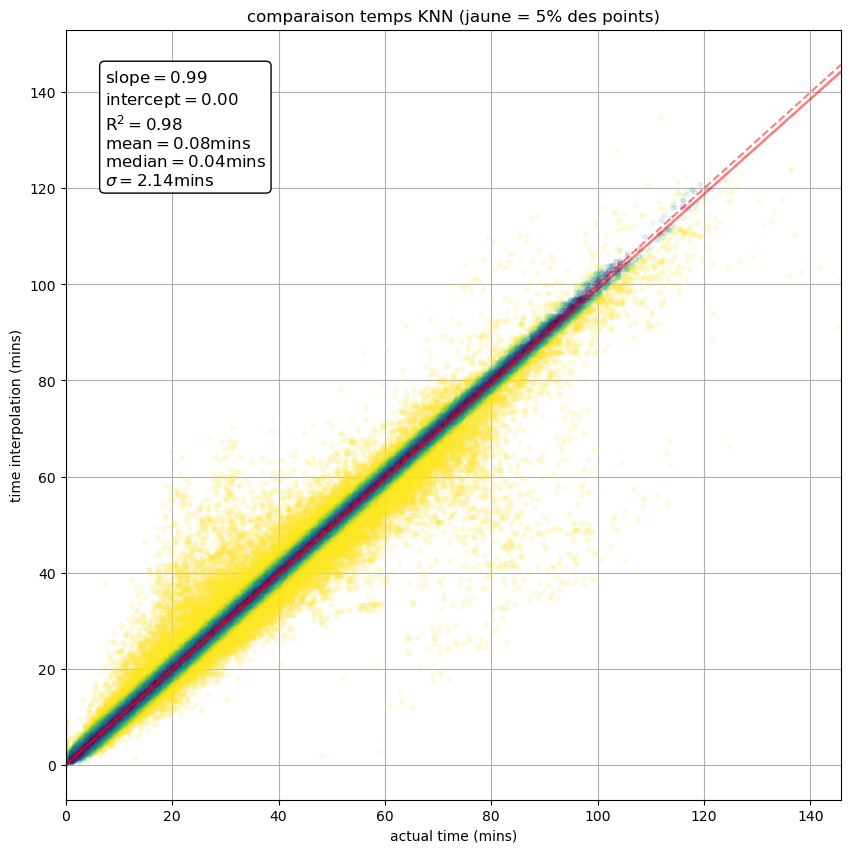

In [186]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10,10))

plt.scatter(x,y,
            s=10,
            c=errors,
            norm=matplotlib.colors.Normalize(vmin=0, vmax=errors.quantile(0.95), clip=True),
            alpha=0.1)


maxvalue = max(max(x),max(y))
plt.plot([0,maxvalue],[0,maxvalue],'--r',alpha=0.5)
mean = np.mean(x - y)
median =np.median(x - y)
sigma = np.std(x-y)

textstr = '\n'.join((
    r'$\mathrm{slope}=%.2f$' % (slope, ),
    r'$\mathrm{intercept}=%.2f$' % (intercept, ),
    r'$\mathrm{R^2}=%.2f$' % (r2, ),
     r'$\mathrm{mean}=%.2f$mins' % (mean, ),
    r'$\mathrm{median}=%.2f$mins' % (median, ),
    r'$\sigma=%.2f$mins' % (sigma, )))
# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='white', alpha=1)
# place a text box in upper left in axes coords
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=props)
plt.plot(x,x*slope+intercept,'r',alpha=0.5)
#plt.plot(x_worst,x_worst*slope_worst+intercept,'r',alpha=0.3)

plt.grid(True,'major',linestyle='-',axis='both')
ax.set_axisbelow(True)
plt.xlim([0,max(x)])
plt.xlabel('actual time (mins)')
plt.ylabel('time interpolation (mins)')
plt.title('comparaison temps KNN (jaune = 5% des points)')


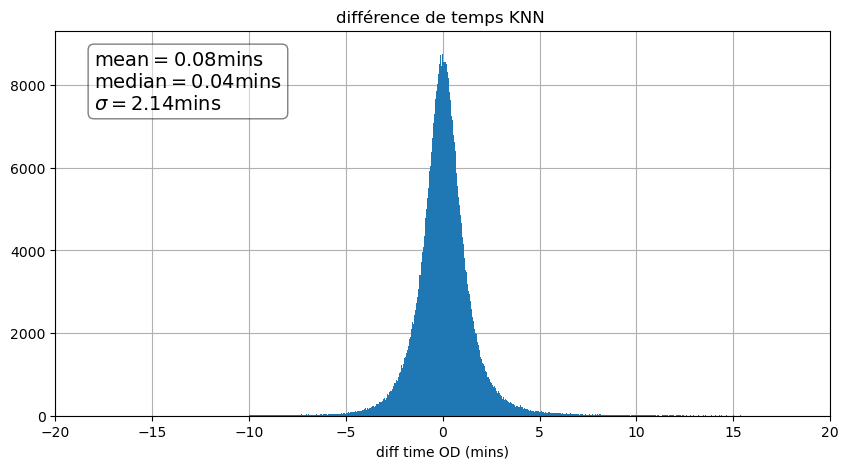

In [187]:
fig, ax = plt.subplots(figsize=(10,5))
plt.hist(x-y,bins=np.linspace(-10,20, 1000))
plt.xlabel('diff time OD (mins)')
mean = np.mean(x - y)
median =np.median(x - y)
sigma = np.std(x-y)
textstr = '\n'.join((
    r'$\mathrm{mean}=%.2f$mins' % (mean, ),
    r'$\mathrm{median}=%.2f$mins' % (median, ),
    r'$\sigma=%.2f$mins' % (sigma, )))

# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
plt.grid(True,'major',linestyle='-',axis='both')
ax.set_axisbelow(True)
plt.xlim([-20,20])
# place a text box in upper left in axes coords
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
plt.title('différence de temps KNN ')
#plt.title('différence de temps (best solution - quetzal) pour chaque OD' +city+relgap)


plt.show()

Text(0.5, 1.0, 'comparaison temps knn (jaune = 95% percentille de la MAPE)')

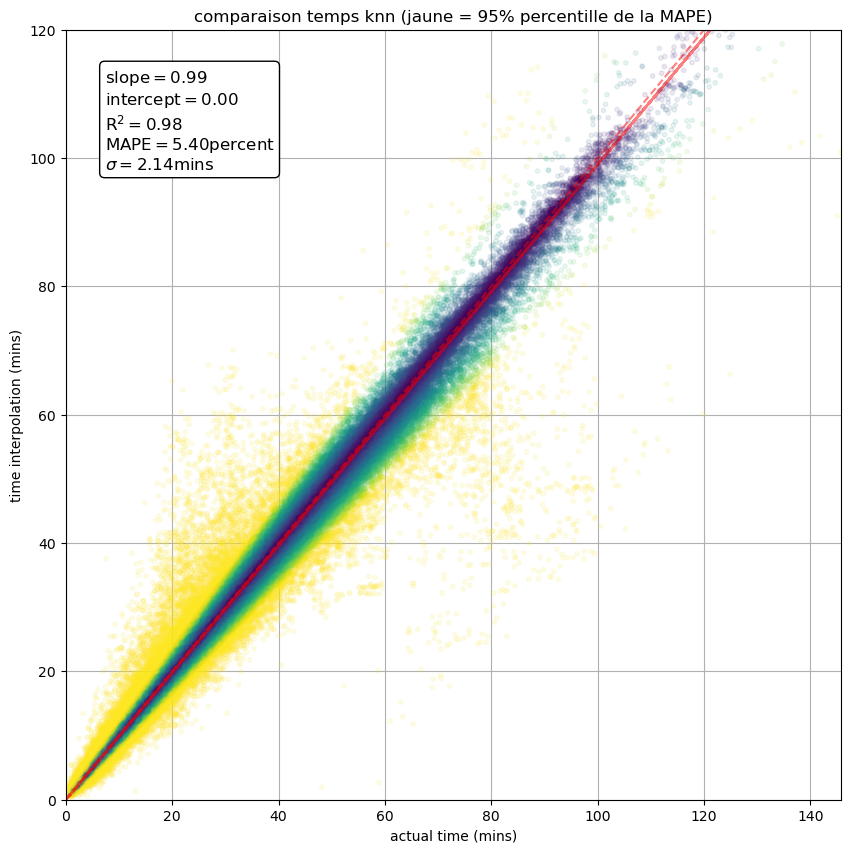

In [188]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10,10))

plt.scatter(x,y,
            s=10,
            c=MAPE,
            norm=matplotlib.colors.Normalize(vmin=0, vmax=MAPE.quantile(0.95), clip=True),
            alpha=0.1)


maxvalue = max(max(x),max(y))
plt.plot([0,maxvalue],[0,maxvalue],'--r',alpha=0.5)
sigma = np.std(x-y)

textstr = '\n'.join((
    r'$\mathrm{slope}=%.2f$' % (slope, ),
    r'$\mathrm{intercept}=%.2f$' % (intercept, ),
    r'$\mathrm{R^2}=%.2f$' % (r2, ),
    r'$\mathrm{MAPE}=%.2f$percent' % (100*np.nanmean(MAPE[np.isfinite(MAPE)]), ),
    r'$\sigma=%.2f$mins' % (sigma, )))
# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='white', alpha=1)
# place a text box in upper left in axes coords
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=props)
plt.plot(x,x*slope+intercept,'r',alpha=0.5)
#plt.plot(x_worst,x_worst*slope_worst+intercept,'r',alpha=0.3)
plt.xlim([0,120])
plt.ylim([0,120])
plt.grid(True,'major',linestyle='-',axis='both')
ax.set_axisbelow(True)
plt.xlim([0,max(x)])
plt.xlabel('actual time (mins)')
plt.ylabel('time interpolation (mins)')
plt.title('comparaison temps knn (jaune = 95% percentille de la MAPE)')


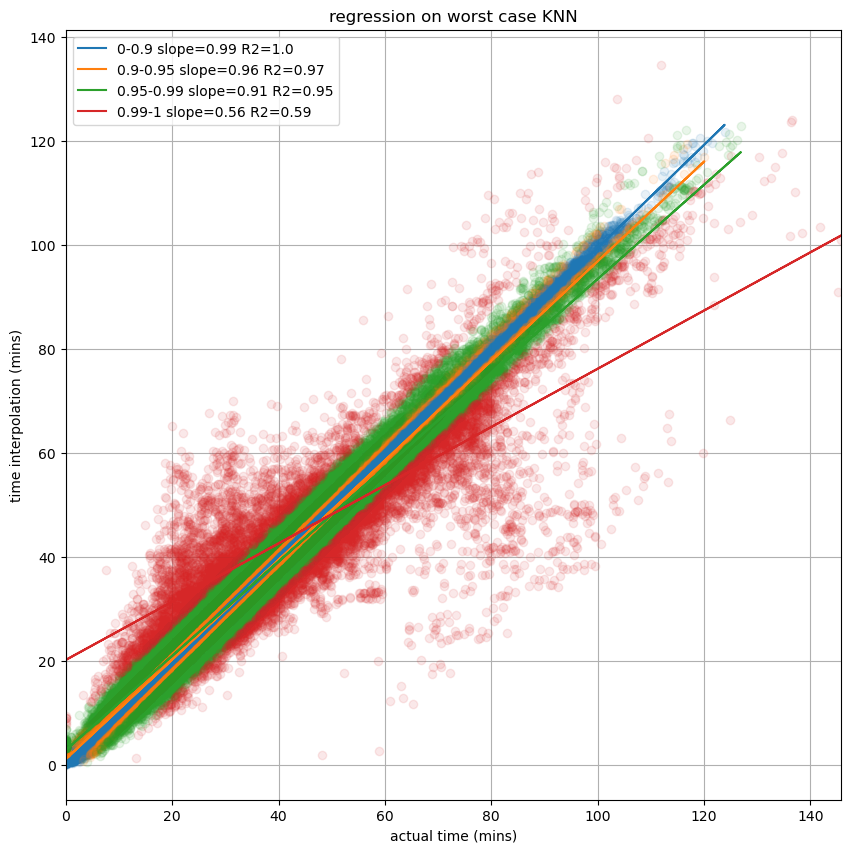

In [190]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10,10))
quant = [0,0.9,0.95,0.99,1]
for i in range(len(quant)-1):
    cond = (errors>=errors.quantile(quant[i])) & (errors<errors.quantile(quant[i+1]))
    yw = predictions[cond]/60
    xw = y_test[cond].values/60
    regr = linear_model.LinearRegression(fit_intercept=True)#
    regr.fit(xw[:, np.newaxis], yw)
    y_predw = regr.predict(xw[:, np.newaxis])
    r2 = r2_score(yw, y_predw)
    regr.fit(xw[:, np.newaxis], yw)
    slopew = regr.coef_[0]
    interceptw = regr.intercept_
    label = str(quant[i]) + '-'+ str(quant[i+1]) + ' slope='+str(round(slopew,2)) + ' R2=' +str(round(r2,2))
    metric.loc[model_name,str(quant[i]) + '-'+ str(quant[i+1]) + '-slope'] = slopew
    metric.loc[model_name,str(quant[i]) + '-'+ str(quant[i+1]) + '-r2'] = round(r2,2)

    plt.scatter(xw,yw,alpha=0.1)
    line = plt.plot(xw,xw*slopew+interceptw,alpha=1,label=label)
    #plt.plot(x_worst,x_worst*slope_worst+intercept,'r',alpha=0.3)

plt.grid(True,'major',linestyle='-',axis='both')
ax.set_axisbelow(True)
plt.xlim([0,max(x)])
plt.xlabel('actual time (mins)')
plt.ylabel('time interpolation (mins)')
plt.title('regression on worst case KNN')
plt.legend()      

# comparaison 

In [ ]:
fig, ax = plt.subplots(2,2,figsize=(10,10))
metric['MAE'].plot(kind='bar',ax=ax[0,0],ylabel='MAE (mins)')
metric['MAPE'].plot(kind='bar',ax=ax[0,1],ylabel='MAPE (%)')
metric['r2'].plot(kind='bar',ax=ax[1,0],ylabel='R2')
metric['slope'].plot(kind='bar',ax=ax[1,1],ylabel='Slope',ylim=[0.8,1])
plt.show()

In [ ]:
fig, ax = plt.subplots(2,2,figsize=(10,10))
metric['diff_mean'].plot(kind='bar',ax=ax[0,0],ylabel='mean (mins)')
metric['diff_median'].plot(kind='bar',ax=ax[0,1],ylabel='median (mins)')
metric['diff_STD'].plot(kind='bar',ax=ax[1,0],ylabel='STD (mins)')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))

metric[metric.columns[['-slope' in col for col in metric.columns]]].plot(ax=ax,kind='bar',ylim=[0,1.02],ylabel='slope')
plt.grid(True,'major',linestyle='-',axis='both')
ax.set_axisbelow(True)

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))

metric[metric.columns[['-r2' in col for col in metric.columns]]].plot(ax=ax,kind='bar',ylim=[0,1],ylabel='R2')
plt.grid(True,'major',linestyle='-',axis='both')
ax.set_axisbelow(True)

In [ ]:
df = od_time_quebec.stack().reset_index().rename(columns={'level_0':'origin','level_1':'destination',0:'time'})
df.loc[X_test.index,'predictions']=predictions
df.loc[X_test.index,'errors']=errors
df.loc[X_test.index,'MAPE']=MAPE

In [ ]:
wcond = errors[(errors>3380.3) & (errors<3381)]
wcond = MAPE[np.isfinite(MAPE)][MAPE>10]
wcond = errors[(errors>3000)]
ori = df.loc[wcond.index]['origin'].values
des = df.loc[wcond.index]['destination'].values
wcond

In [ ]:
df.loc[wcond.index]

In [ ]:
X_test.loc[593621]

In [583]:
3531.176137/60

58.85293561666666

In [584]:
len(predictions)

720725

In [585]:
training_nodes = set(df.loc[X_train.index]['origin']).union(set(df.loc[X_train.index]['destination']))

<IPython.core.display.Javascript object>


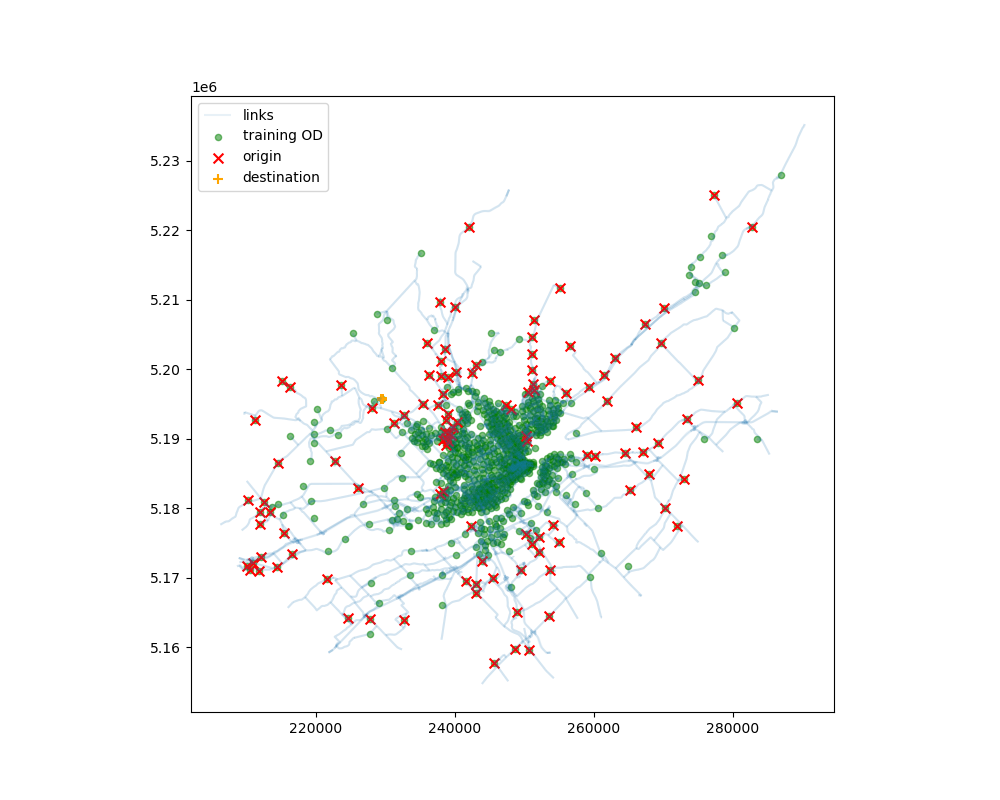

/var/folders/p9/tw29fgs17yvfs17876xjxjqh0000gn/T/ipykernel_39259/655541722.py:4: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  nodes.loc[training_nodes].plot(ax=ax,color='g',markersize=20,alpha=0.5)


In [586]:
%matplotlib notebook
f, ax = plt.subplots(figsize=(10,8))
links.plot(ax=ax,alpha=0.1)
nodes.loc[training_nodes].plot(ax=ax,color='g',markersize=20,alpha=0.5)
nodes.loc[ori].plot(ax=ax,color='red',marker='x',markersize=50)
nodes.loc[des].plot(ax=ax,color='orange',marker='+',markersize=50)

plt.legend(['links','training OD','origin','destination'])

# loop

In [167]:
%%time
hdf = pd.DataFrame()
metrics = pd.DataFrame()
for param in [('distance',1),('distance',2),('distance',3),('distance',5),('distance',7),('distance',10)]:
    model_name = 'KNN'+str(param)
    print(model_name)
    neigh = KNeighborsRegressor(weights=param[0],algorithm='ball_tree', n_neighbors=param[1],)
    neigh.fit(X_train.values, y_train.values)

    predictions = neigh.predict(X_test.values)
    errors = abs(predictions - y_test)
    MAPE = errors/y_test

    x = y_test.values/60
    y = predictions/60
    regr = linear_model.LinearRegression(fit_intercept=False)#

    regr.fit(x[:, np.newaxis], y)
    y_pred = regr.predict(x[:, np.newaxis])
    r2 = r2_score(y, y_pred)
    slope = regr.coef_[0]
    intercept=0


    hdf[model_name] = x-y
    sigma = np.std(x-y)
    mean = np.mean(x - y)
    median =np.median(x - y)

    metrics.loc[model_name,'MAE'] = round(np.mean(errors)/60, 2)
    metrics.loc[model_name,'MAPE'] = 100*np.nanmean(MAPE[np.isfinite(MAPE)])
    metrics.loc[model_name,'r2'] = r2
    metrics.loc[model_name,'slope'] = slope
    metrics.loc[model_name,'diff_mean'] = mean
    metrics.loc[model_name,'diff_median'] = median
    metrics.loc[model_name,'diff_STD'] = sigma

    quant = [0,0.9,0.95,0.99,1]
    for i in range(len(quant)-1):
        cond = (errors>=errors.quantile(quant[i])) & (errors<errors.quantile(quant[i+1]))
        yw = predictions[cond]/60
        xw = y_test[cond].values/60
        regr = linear_model.LinearRegression(fit_intercept=True)#
        regr.fit(xw[:, np.newaxis], yw)
        y_predw = regr.predict(xw[:, np.newaxis])
        r2 = r2_score(yw, y_predw)
        regr.fit(xw[:, np.newaxis], yw)
        slopew = regr.coef_[0]
        metrics.loc[model_name,str(quant[i]) + '-'+ str(quant[i+1]) + '-slope'] = slopew
        metrics.loc[model_name,str(quant[i]) + '-'+ str(quant[i+1]) + '-r2'] = round(r2,2)



KNN('distance', 1)
KNN('distance', 2)
KNN('distance', 3)
KNN('distance', 5)
KNN('distance', 7)
KNN('distance', 10)
CPU times: user 5min 28s, sys: 3.55 s, total: 5min 31s
Wall time: 5min 23s


In [168]:
from sklearn.ensemble import RandomForestRegressor


In [ ]:
%%time
for param in [(50,None),(100,None),(200,None),(500,None),(200,5),(200,10),(200,20),(500,5),(500,10),(500,20)]:
    model_name = 'RF'+str(param)
    print(model_name)
    # Instantiate model with 1000 decision trees
    rf = RandomForestRegressor(n_estimators = param[0], random_state = 42,max_depth=param[1])
    # Train the model on training data
    rf.fit(X_train.values, y_train);

    predictions = rf.predict(X_test.values)
    errors = abs(predictions - y_test)
    MAPE = errors/y_test

    x = y_test.values/60
    y = predictions/60
    regr = linear_model.LinearRegression(fit_intercept=False)#

    regr.fit(x[:, np.newaxis], y)
    y_pred = regr.predict(x[:, np.newaxis])
    r2 = r2_score(y, y_pred)
    slope = regr.coef_[0]
    intercept=0


    hdf[model_name] = x-y
    sigma = np.std(x-y)
    mean = np.mean(x - y)
    median =np.median(x - y)

    metrics.loc[model_name,'MAE'] = round(np.mean(errors)/60, 2)
    metrics.loc[model_name,'MAPE'] = 100*np.nanmean(MAPE[np.isfinite(MAPE)])
    metrics.loc[model_name,'r2'] = r2
    metrics.loc[model_name,'slope'] = slope
    metrics.loc[model_name,'diff_mean'] = mean
    metrics.loc[model_name,'diff_median'] = median
    metrics.loc[model_name,'diff_STD'] = sigma

    quant = [0,0.9,0.95,0.99,1]
    for i in range(len(quant)-1):
        cond = (errors>=errors.quantile(quant[i])) & (errors<errors.quantile(quant[i+1]))
        yw = predictions[cond]/60
        xw = y_test[cond].values/60
        regr = linear_model.LinearRegression(fit_intercept=True)#
        regr.fit(xw[:, np.newaxis], yw)
        y_predw = regr.predict(xw[:, np.newaxis])
        r2 = r2_score(yw, y_predw)
        regr.fit(xw[:, np.newaxis], yw)
        slopew = regr.coef_[0]
        metrics.loc[model_name,str(quant[i]) + '-'+ str(quant[i+1]) + '-slope'] = slopew
        metrics.loc[model_name,str(quant[i]) + '-'+ str(quant[i+1]) + '-r2'] = round(r2,2)



RF(50, None)
RF(100, None)
RF(200, None)
RF(500, None)


In [170]:
metrics

,MAE,MAPE,r2,slope,diff_mean,diff_median,diff_STD,0-0.9-slope,0-0.9-r2,0.9-0.95-slope,0.9-0.95-r2,0.95-0.99-slope,0.95-0.99-r2,0.99-1-slope,0.99-1-r2
"KNN('distance', 1)",1.30,6.493717,0.973891,0.993965,0.045520,0.024657,2.431528,0.996406,0.99,0.974347,0.96,0.951326,0.93,0.614108,0.43
"KNN('distance', 2)",1.14,5.614083,0.979276,0.992733,0.056327,0.030395,2.157099,0.995455,1.00,0.971327,0.97,0.937538,0.94,0.605390,0.54
"KNN('distance', 3)",1.11,5.410673,0.980126,0.991831,0.061704,0.031159,2.108509,0.994657,1.00,0.965074,0.97,0.922747,0.95,0.597568,0.57
"KNN('distance', 5)",1.13,5.399234,0.979477,0.990021,0.075639,0.035905,2.137420,0.993041,1.00,0.957495,0.97,0.905876,0.95,0.559883,0.59
"KNN('distance', 7)",1.16,5.516131,0.978080,0.988455,0.087780,0.041381,2.205000,0.991790,1.00,0.949641,0.97,0.890662,0.94,0.536386,0.60
"KNN('distance', 10)",1.22,5.727842,0.975993,0.986402,0.105519,0.047520,2.302830,0.990311,0.99,0.938543,0.97,0.869486,0.93,0.512122,0.60
"RF(50, None)",1.20,5.796686,0.979890,0.992367,0.005461,-0.014984,2.111031,0.991482,0.99,0.943483,0.97,0.894920,0.94,0.668768,0.67
"RF(100, None)",1.19,5.738611,0.980307,0.992333,0.005677,-0.016848,2.088699,0.991347,0.99,0.944682,0.97,0.895440,0.94,0.672494,0.67
"RF(200, None)",1.18,5.708365,0.980474,0.992309,0.006459,-0.017651,2.079791,0.991371,0.99,0.944311,0.97,0.894781,0.94,0.678111,0.67


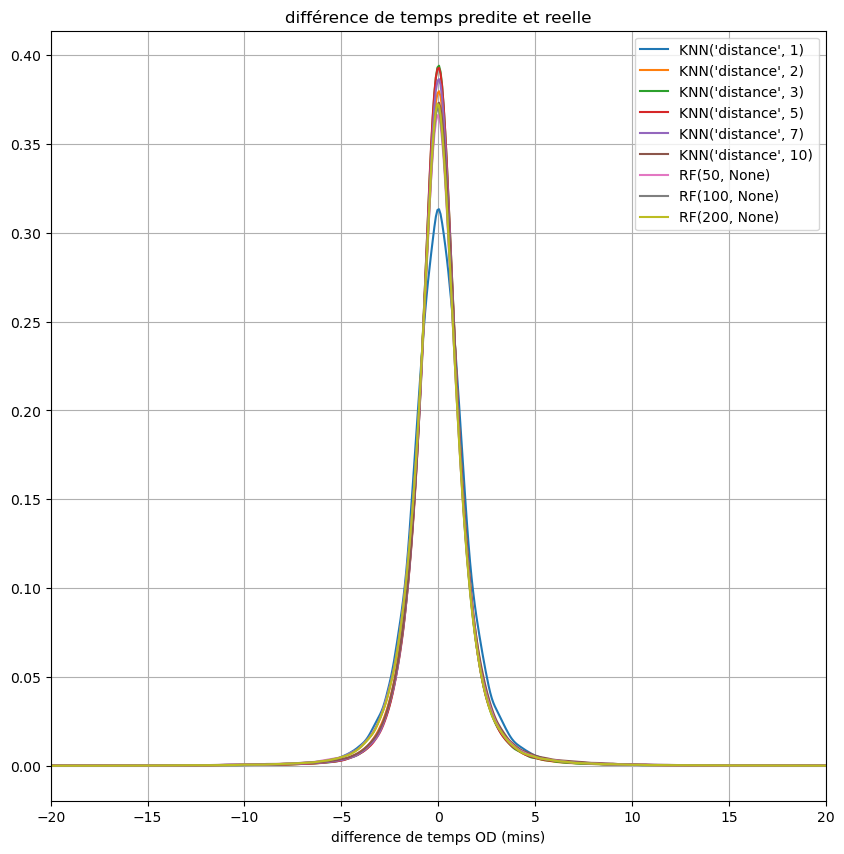

In [171]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10,10))
import scipy.stats as stats
x=np.linspace(-20, 20, 500)
for name in hdf.columns:
    density = stats.gaussian_kde(hdf[name])
    plt.plot(x,density(x))
plt.grid(True,'major',linestyle='-',axis='both')
ax.set_axisbelow(True)
plt.xlim([-20,20])
plt.legend(hdf.columns)
plt.xlabel('difference de temps OD (mins)')

plt.title('différence de temps predite et reelle')
plt.show()

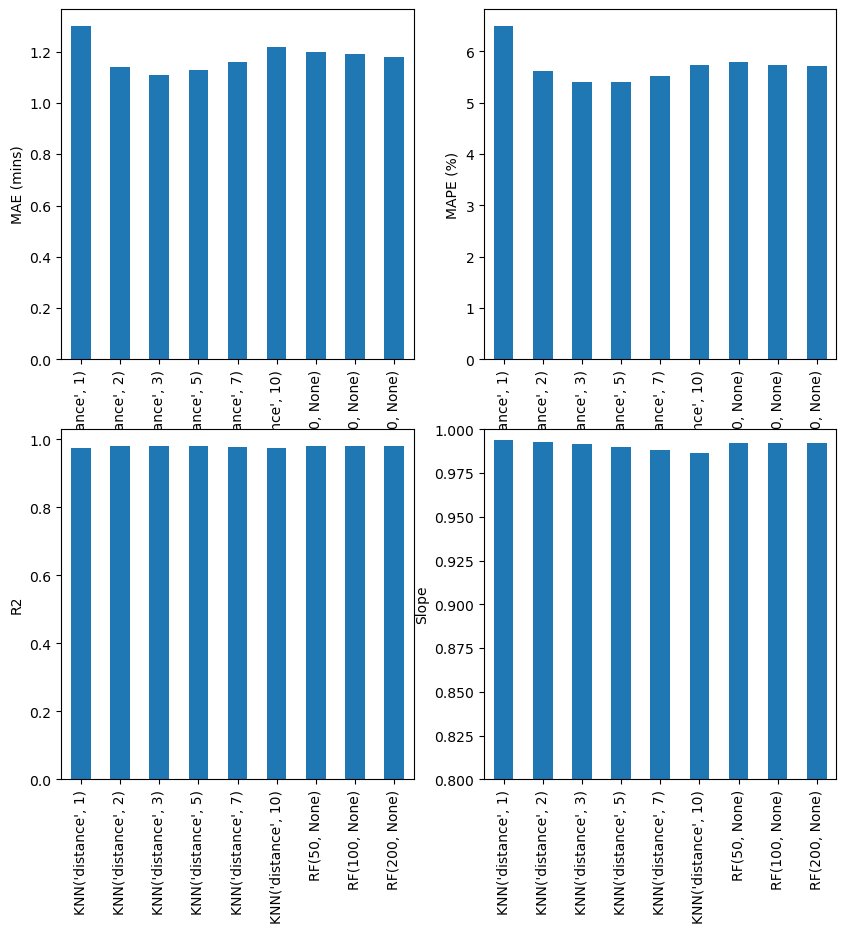

In [172]:
fig, ax = plt.subplots(2,2,figsize=(10,10))
metrics['MAE'].plot(kind='bar',ax=ax[0,0],ylabel='MAE (mins)')
metrics['MAPE'].plot(kind='bar',ax=ax[0,1],ylabel='MAPE (%)')
metrics['r2'].plot(kind='bar',ax=ax[1,0],ylabel='R2')
metrics['slope'].plot(kind='bar',ax=ax[1,1],ylabel='Slope',ylim=[0.8,1])
plt.show()

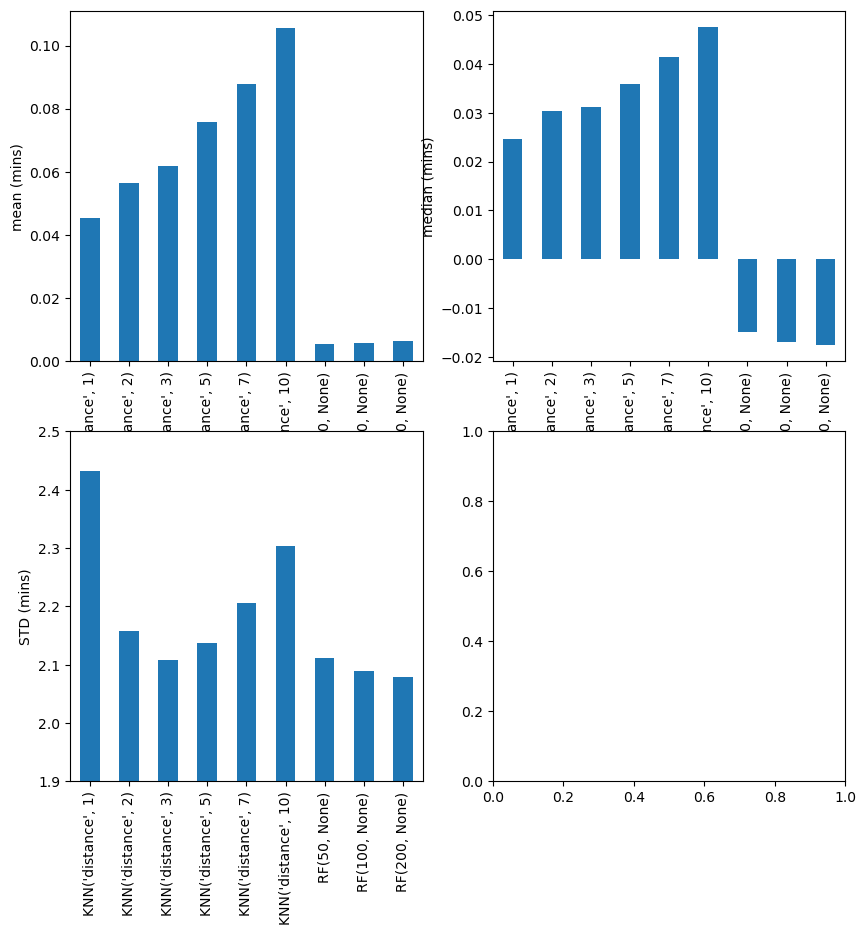

In [177]:
fig, ax = plt.subplots(2,2,figsize=(10,10))
metrics['diff_mean'].plot(kind='bar',ax=ax[0,0],ylabel='mean (mins)')
metrics['diff_median'].plot(kind='bar',ax=ax[0,1],ylabel='median (mins)')
metrics['diff_STD'].plot(kind='bar',ax=ax[1,0],ylabel='STD (mins)',ylim=[1.9,2.5])
plt.show()

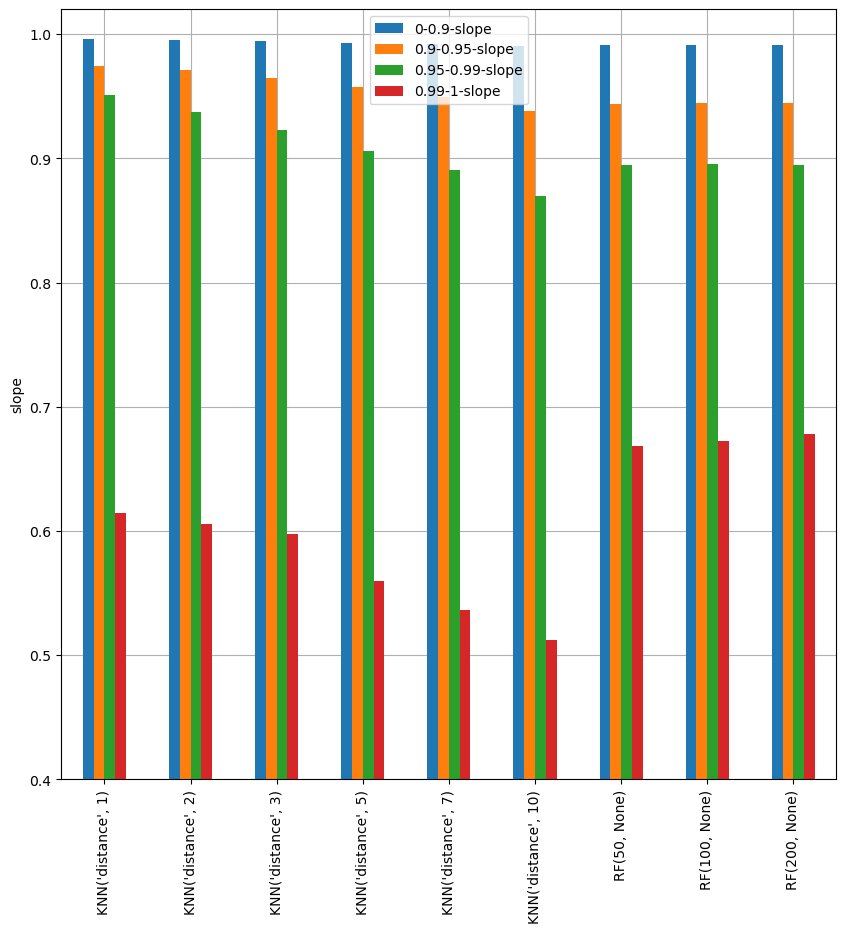

In [178]:
fig, ax = plt.subplots(figsize=(10,10))

metrics[metrics.columns[['-slope' in col for col in metrics.columns]]].plot(ax=ax,kind='bar',ylim=[0.4,1.02],ylabel='slope')
plt.grid(True,'major',linestyle='-',axis='both')
ax.set_axisbelow(True)

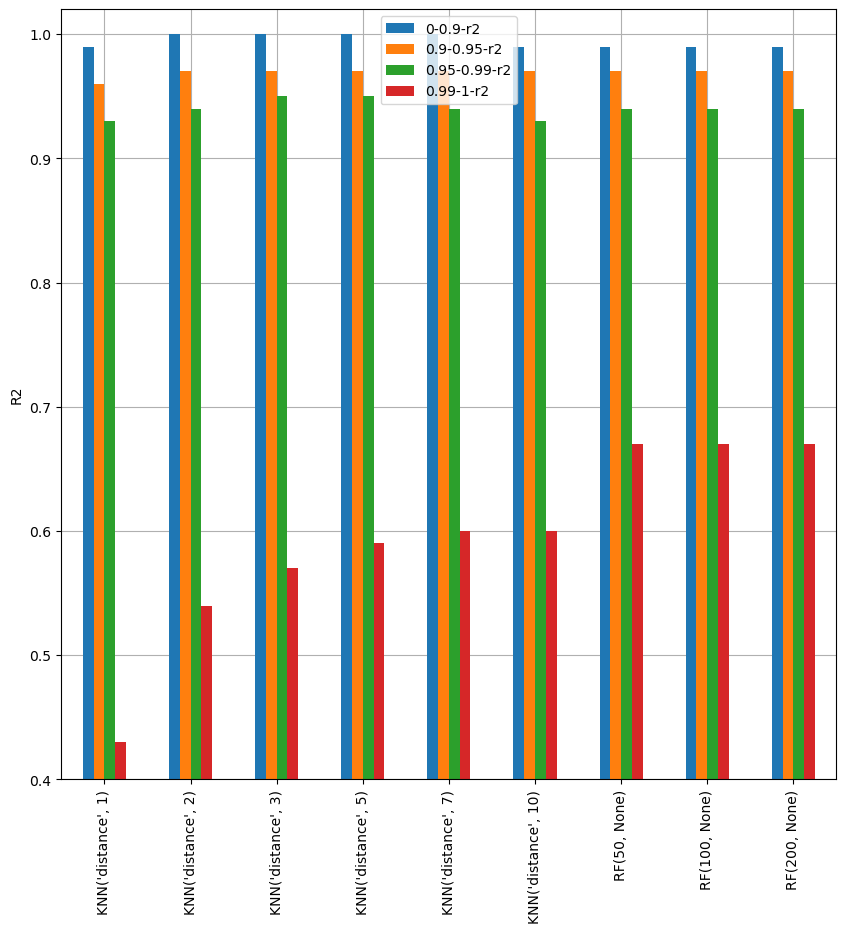

In [179]:
fig, ax = plt.subplots(figsize=(10,10))

metrics[metrics.columns[['-r2' in col for col in metrics.columns]]].plot(ax=ax,kind='bar',ylim=[0.4,1.02],ylabel='R2')
plt.grid(True,'major',linestyle='-',axis='both')
ax.set_axisbelow(True)

In [ ]:
# variogramme pour changer la fonction weight ou tester des fonctions.
# utiliser un model et un residue. regarder varuigram sur les residue
# Entrainer sur Y  = Dijktra_20kmh - dijktra_reelle (prendre la vitesse moyenmne sur tout le reseau.)

In [1]:
from sklearn.neighbors import KNeighborsRegressor
KNeighborsRegressor

sklearn.neighbors._regression.KNeighborsRegressor

In [3]:
    #Ox, Oy, Dx, Dy, dist
trainx=[[10,10,10,-10],
      [20,10,20,-10]]

trainy=[0,1]

In [131]:
import numpy as np
def func1(x):
    return 1/x
def func2(x):
    return 1/(x**2)
def func3(x):
    return 1/(x**1.84)
def func4(x):
    return 1/((x**1.84)*10**(-1.68))
def func5(x):
    return 1/(np.exp(0.00344*x)-1)
def func6(x):
    return 1/(np.exp(x)-1)

from sklearn.neighbors import KNeighborsRegressor


In [136]:
neigh = KNeighborsRegressor(weights=func2,algorithm='ball_tree', n_neighbors=2,)
neigh.fit(trainx, trainy)
val = [[17,10,17,-10]]
neigh.predict(val)

array([0.84482759])

In [121]:
func5(0)

/var/folders/p9/tw29fgs17yvfs17876xjxjqh0000gn/T/ipykernel_64420/1942032926.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  return 1/(np.exp(0.00344*x)-1)


inf

In [122]:
func1(100)

0.01

In [123]:
x=np.linspace(0.1,10.1,100)

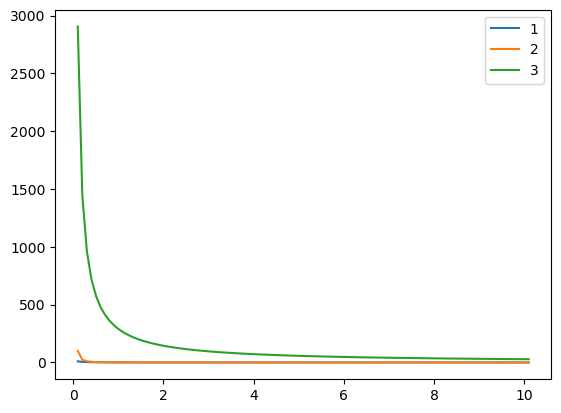

In [130]:
plt.plot(x,func1(x))
plt.plot(x,func2(x))
plt.plot(x,func5(x))
plt.legend([1,2,3])

In [110]:
np.exp(0)

1.0